In [ ]:
import pandas as pd
import yfinance as yf
import datetime
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  
warnings.filterwarnings('ignore')

In [ ]:
def download_stocks_history(stksybl):
    stock_final = pd.DataFrame()
    stock_symbol = stksybl 
    try:
        stock = []
        stock = yf.download(stock_symbol,period='5y')
        if len(stock) == 0:
            None
        else:
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
    fileName = 'data/'+str(stock_symbol)+'_stock.csv'
    stock_final.to_csv(fileName) # save data to a csv file for later use
    return stock_final

In [ ]:
companyCode = 'TCS'
stocks_data = download_stocks_history(companyCode+".NS") 



[*********************100%***********************]  1 of 1 completed


In [ ]:
stocks_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-12,1248.500000,1256.449951,1235.199951,1243.599976,1122.983276,1626506
2017-06-13,1232.500000,1240.550049,1223.500000,1225.775024,1119.262207,1175414
2017-06-14,1227.500000,1238.000000,1227.500000,1235.099976,1127.776855,1489142
2017-06-15,1234.500000,1234.849976,1202.500000,1205.599976,1100.840210,2997198
2017-06-16,1207.474976,1217.500000,1193.250000,1199.849976,1095.589966,2450426


In [ ]:
stocks_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-06,3418.000000,3453.000000,3377.149902,3430.949951,3430.949951,1084210
2022-06-07,3401.050049,3418.850098,3356.000000,3362.699951,3362.699951,2308256
2022-06-08,3380.149902,3413.949951,3346.500000,3404.149902,3404.149902,2185707
2022-06-09,3385.000000,3437.000000,3353.100098,3427.100098,3427.100098,1279197
2022-06-10,3382.000000,3393.000000,3352.000000,3355.949951,3355.949951,1482121


In [ ]:
stocks_data.rename(columns = {'Adj Close':'AdjClose'}, inplace = True)

In [ ]:
stocks_data_copy =  stocks_data.copy()

# EDA & Data Visualization

In [ ]:
def initial_EDA():
    print("Summary \n\n",stocks_data.describe())
    print("\n-------------------------------------------\n")
    print("Shape\n\n",stocks_data.shape)
    print("\n-------------------------------------------\n")
    print("Data Types\n\n",stocks_data.dtypes)
    print("\n-------------------------------------------\n")
    print("Checking Missed valued\n\n",stocks_data.isnull().sum())
    print("\n-------------------------------------------\n")
    print("Checking Duplicate Values\n\n",stocks_data.duplicated().sum())
    print("\n-------------------------------------------\n")
    print("Checking Corelation\n",stocks_data.corr())
initial_EDA()

Summary 

               Open         High          Low        Close     AdjClose  \
count  1236.000000  1236.000000  1236.000000  1236.000000  1236.000000   
mean   2364.135395  2388.779143  2337.874662  2362.837803  2278.908230   
std     780.380253   785.619714   772.903228   779.162281   810.947407   
min    1162.199951  1178.224976  1161.550049  1165.974976  1064.658569   
25%    1873.750000  1898.975006  1850.950012  1875.474976  1757.241119   
50%    2140.149902  2165.000000  2114.299927  2138.200073  2035.755127   
75%    3111.449951  3148.750000  3085.837524  3114.312500  3061.168884   
max    4033.949951  4043.000000  3980.000000  4019.149902  3985.254883   

             Volume  
count  1.236000e+03  
mean   3.088509e+06  
std    3.084839e+06  
min    8.682200e+04  
25%    1.874828e+06  
50%    2.578144e+06  
75%    3.550928e+06  
max    8.806715e+07  

-------------------------------------------

Shape

 (1236, 6)

-------------------------------------------

Data Types

 O

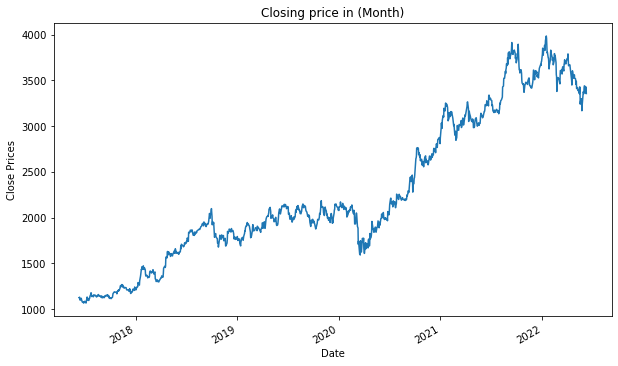

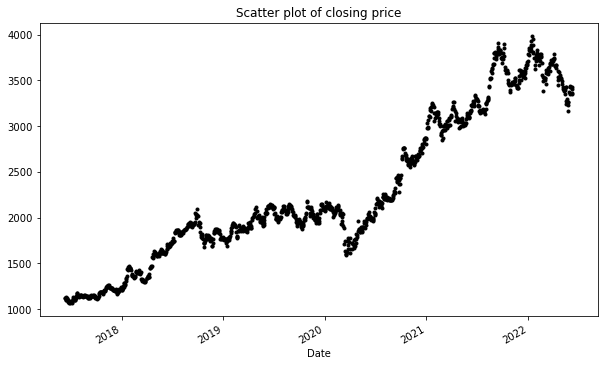

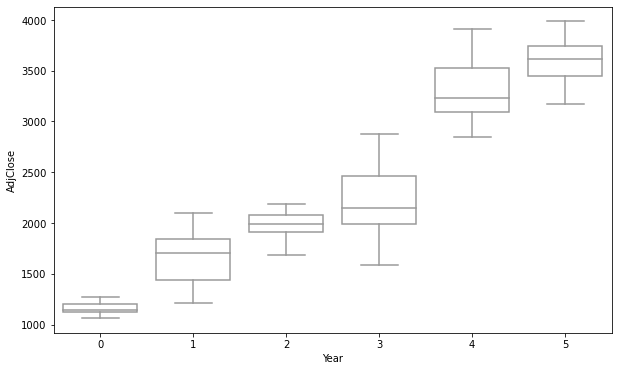

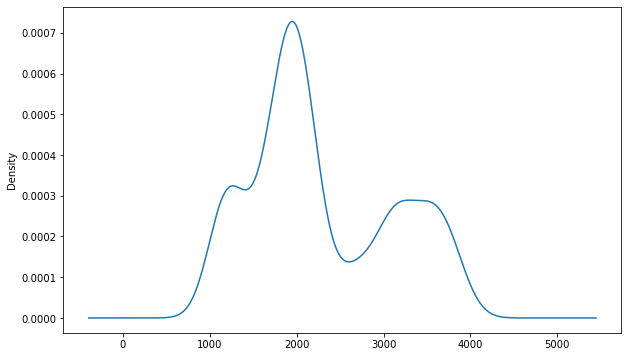

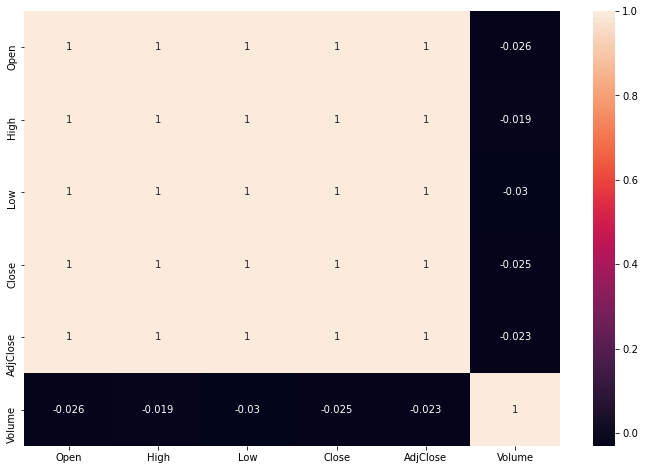

In [ ]:
def plot_diagram():
    #plot close price
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Close Prices')
    plot1_df = stocks_data.groupby(["Date"])["AdjClose"].mean()
    plot1_df.plot()
    plt.title('Closing price in (Month)')
    plt.show()
    
    #scatter plot of the sales
    plt.figure(figsize=(10,6))
    df_close = stocks_data['AdjClose']
    df_close.plot(style='k.')
    plt.title('Scatter plot of closing price')
    plt.show()

    #Boxplot
    plt.figure(figsize=(10,6))
    data_boxplot = []
    for year in range(2017, 2023):
        data_boxplot.append(stocks_data.loc[(stocks_data.index.year == year)]['AdjClose'])

    import seaborn as sns
    ax = plt.gca()
    sns.boxplot(data=data_boxplot, color='w', whis=1.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('AdjClose')
        
    #Distribution of the dataset
    plt.figure(figsize=(10,6))
    df_close.plot(kind='kde')
    plt.show()
    #We can observe a near-normal distribution(bell-curve) over sales values.
    
    #corelation plot
    corr = stocks_data.corr()
    plt.figure(figsize=(12,8))
    sns.heatmap(corr,annot=True)
plot_diagram()

# Model Building

### 1.ARIMA Model Training

<AxesSubplot:ylabel='Density'>

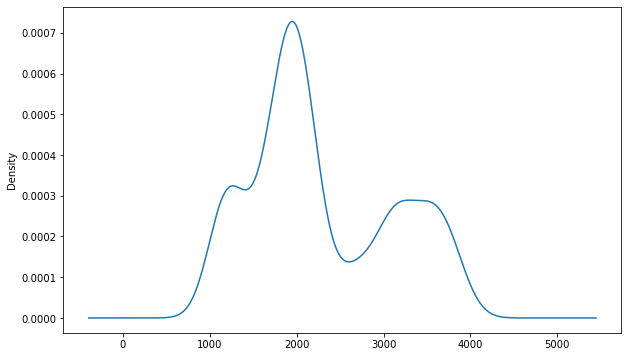

In [ ]:
stocks_data['AdjClose'].plot(kind='kde')

#### Stationarity

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    print(f'Inference: Time Series is {"non" if adft[1]>=0.05 else""} stationary')


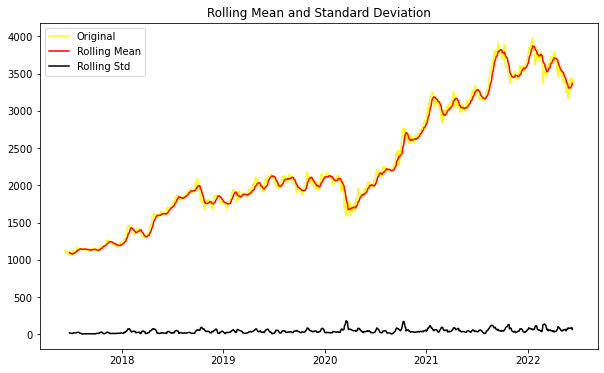

Results of dickey fuller test
Test Statistics                  -0.824466
p-value                           0.811829
No. of lags used                  2.000000
Number of observations used    1233.000000
critical value (1%)              -3.435665
critical value (5%)              -2.863887
critical value (10%)             -2.568020
dtype: float64
Inference: Time Series is non stationary


In [ ]:
test_stationarity(stocks_data['AdjClose'])

### Differencing the data

#### Convert our non-stationary data to stationary data using the differencing method.

In [ ]:
stock_close_diff = stocks_data['AdjClose'].diff()
stock_close_diff.dropna(inplace=True)
stock_close_diff.head()

Date
2017-06-13    -3.721069
2017-06-14     8.514648
2017-06-15   -26.936646
2017-06-16    -5.250244
2017-06-19    14.609741
Name: AdjClose, dtype: float64

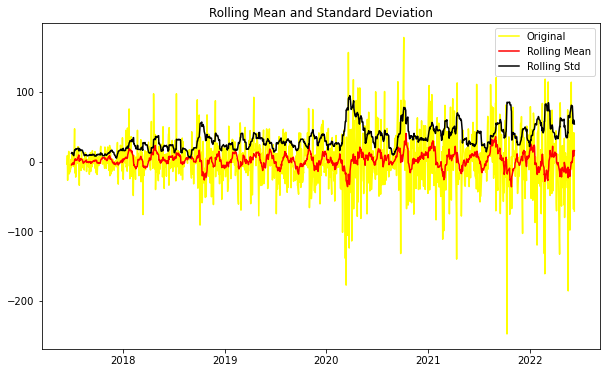

Results of dickey fuller test
Test Statistics                 -26.735453
p-value                           0.000000
No. of lags used                  1.000000
Number of observations used    1233.000000
critical value (1%)              -3.435665
critical value (5%)              -2.863887
critical value (10%)             -2.568020
dtype: float64
Inference: Time Series is  stationary


In [ ]:
test_stationarity(stock_close_diff)

### Plotting Seasonal Differnce

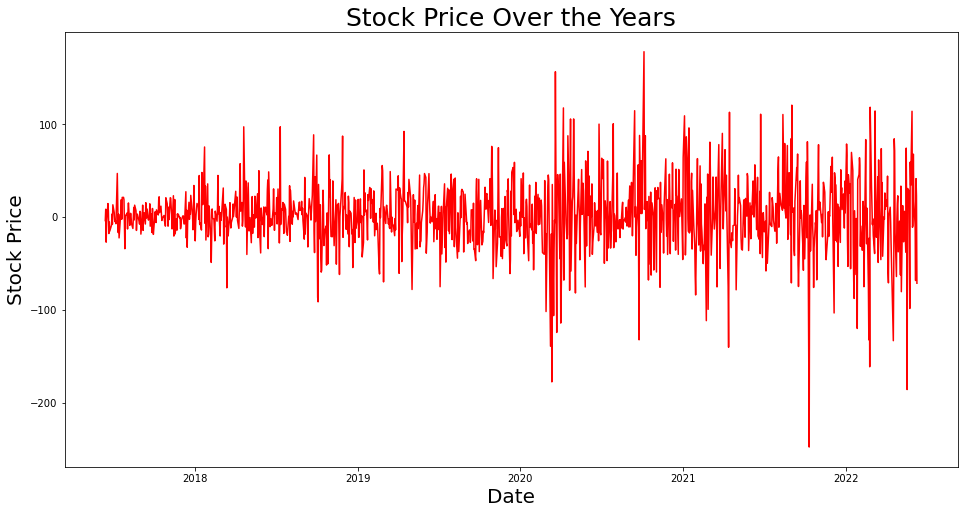

In [ ]:
def decompose_data(stock_close):
    plt.figure(figsize=(16,8))
    plt.plot(stock_close, label='Close Seasonal Diff.',color='r')
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Over the Years',size=25);
decompose_data(stock_close_diff)

### Plotting the autocorrelation plot

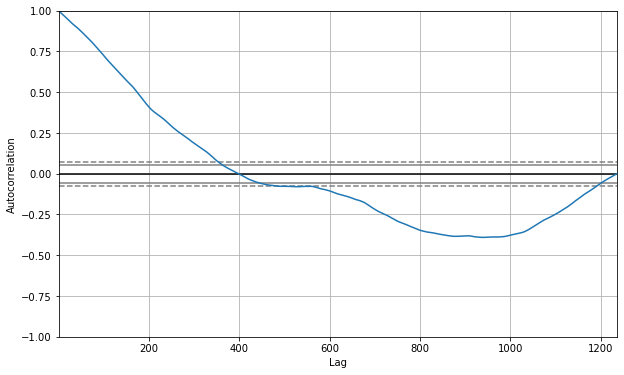

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(stocks_data['AdjClose'])
plt.show() 

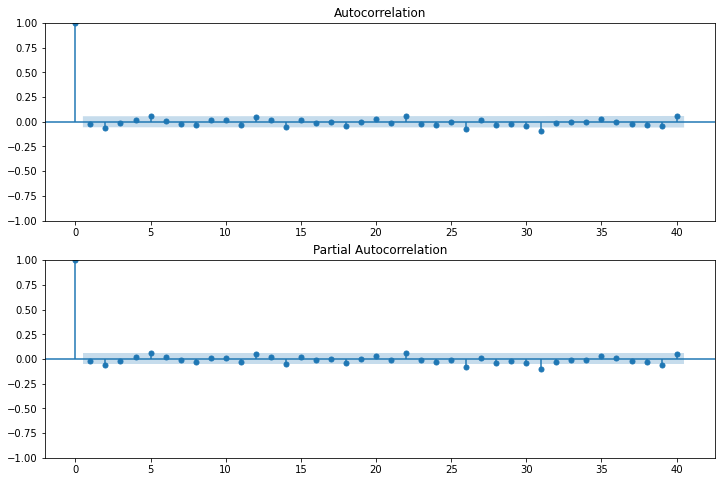

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock_close_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock_close_diff.dropna(),lags=40,ax=ax2)

No handles with labels found to put in legend.


Date
2017-06-12    7.023744
2017-06-13    7.020425
2017-06-14    7.028004
2017-06-15    7.003829
2017-06-16    6.999048
                ...   
2022-06-06    8.140592
2022-06-07    8.120499
2022-06-08    8.132751
2022-06-09    8.139470
2022-06-10    8.118490
Name: AdjClose, Length: 1236, dtype: float64


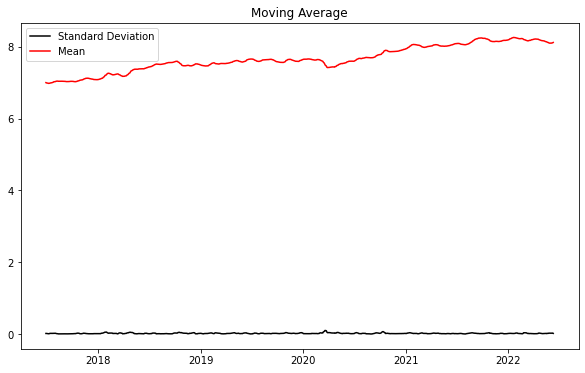

In [ ]:
#if not stationary then eliminate trend Eliminate trend
from pylab import rcParams
stock_log = 0
def log_display(stock_close):
    rcParams['figure.figsize'] = 10, 6
    stock_log = np.log(stock_close)
    print(stock_log)
    moving_avg = stock_log.rolling(12).mean()
    std_dev = stock_log.rolling(12).std() 
    plt.legend(loc='best')
    plt.title('Moving Average')
    plt.plot(std_dev, color ="black", label = "Standard Deviation")
    plt.plot(moving_avg, color="red", label = "Mean")
    plt.legend()
    plt.show()
    return stock_log
stock_log = log_display(stocks_data['AdjClose'])

# Split Data into Train and Test

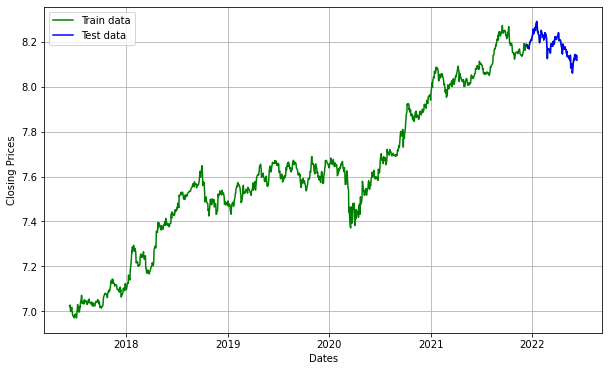

In [ ]:
split_data = dict()
def split_data_fn(stk_log):
    stock_train_data, stock_test_data = stk_log[0:int(len(stk_log)*0.9)], stk_log[int(len(stk_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(stk_log, 'green', label='Train data')
    plt.plot(stock_test_data, 'blue', label='Test data')
    plt.legend()
    split_data["train_data"] = stock_train_data
    split_data["test_data"] = stock_test_data
    return split_data
split_data = split_data_fn(stock_log)

In [ ]:
len(split_data["train_data"])

1112

In [ ]:
split_data["train_data"]

Date
2017-06-12    7.023744
2017-06-13    7.020425
2017-06-14    7.028004
2017-06-15    7.003829
2017-06-16    6.999048
                ...   
2021-12-06    8.162395
2021-12-07    8.175905
2021-12-08    8.187664
2021-12-09    8.180706
2021-12-10    8.190390
Name: AdjClose, Length: 1112, dtype: float64

In [ ]:
lenTestData = len(split_data["test_data"])
lenTestData

124

# Performing Auto Arima

In [ ]:
model_autoARIMA = 0
def create_model_autoARIMA(train_data):
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=3, max_q=3, # maximum p and q
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    print(model_autoARIMA.summary())
    return model_autoARIMA
model_autoARIMA = create_model_autoARIMA(split_data["train_data"])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5989.261, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5990.444, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5990.675, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5986.664, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5989.070, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5989.860, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5987.968, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5987.519, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.595 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1112
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2998.338
Date:                Fri, 10 Jun 2022   AIC                          -5990.675
Time:                       

In [ ]:
bestOrder = model_autoARIMA.order
bestOrder

(0, 1, 1)

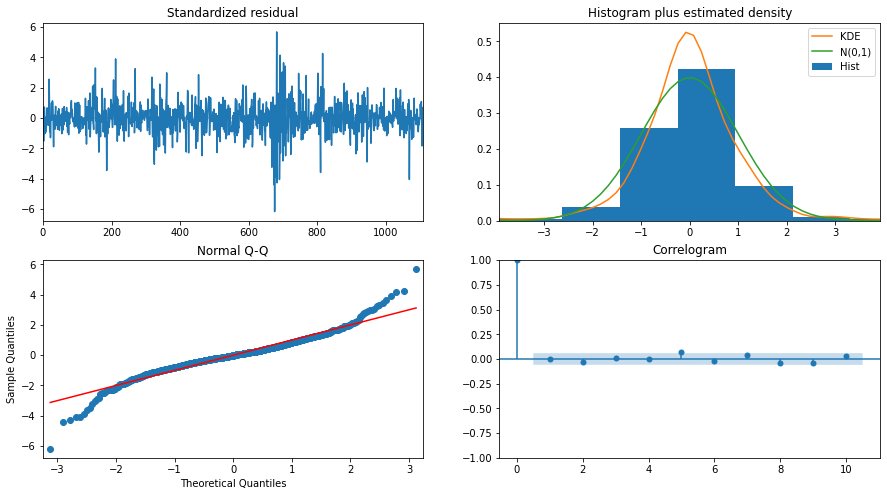

In [ ]:
def plot_model_autoARIMA():
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()
plot_model_autoARIMA()

In [ ]:
fitted=0
def create_final_model(train_data):
    fitted = model_autoARIMA.fit(train_data)
    print(fitted.summary())
    return fitted
fitted = create_final_model(split_data["train_data"])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1112
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2998.338
Date:                Fri, 10 Jun 2022   AIC                          -5990.675
Time:                        15:20:15   BIC                          -5975.636
Sample:                             0   HQIC                         -5984.989
                               - 1112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.000      2.257      0.024       0.000       0.002
ma.L1         -0.0545      0.022     -2.498      0.012      -0.097      -0.012
sigma2         0.0003   6.29e-06     42.163      0.0

### ARIMA - Prediction

In [ ]:
split_data['train_data'].tail()

Date
2021-12-06    8.162395
2021-12-07    8.175905
2021-12-08    8.187664
2021-12-09    8.180706
2021-12-10    8.190390
Name: AdjClose, dtype: float64

In [ ]:
predictArima = model_autoARIMA.predict(n_periods=lenTestData)
predictArima = pd.DataFrame(predictArima,index = split_data["test_data"].index,columns=['Prediction'])

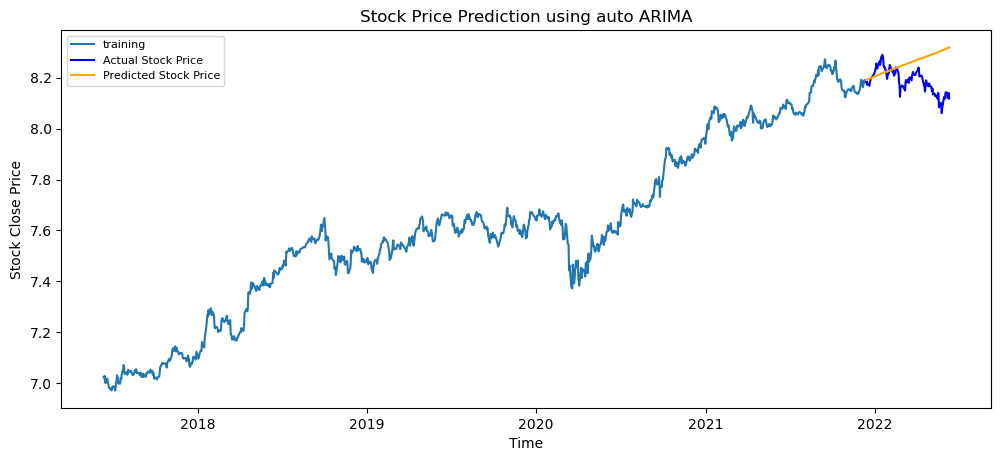

In [ ]:
def plot_arima_forecasting(split_data):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(split_data["train_data"], label='training')
    plt.plot(split_data["test_data"], color = 'blue', label='Actual Stock Price')
    plt.plot(predictArima['Prediction'], color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction using auto ARIMA')
    plt.xlabel('Time')
    plt.ylabel('Stock Close Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
plot_arima_forecasting(split_data)

In [ ]:
predictArima

,Prediction
Date,
2021-12-13,8.190985
2021-12-14,8.192028
2021-12-15,8.193071
2021-12-16,8.194115
2021-12-17,8.195158
...,...
2022-06-06,8.315143
2022-06-07,8.316187
2022-06-08,8.317230


In [ ]:
# report performance
tst_data = split_data["test_data"].values.reshape(len(split_data["test_data"]),1)

arima_rmse = math.sqrt(mean_squared_error(tst_data, predictArima))
print('RMSE: '+str(arima_rmse))
arima_mape = np.mean(np.abs(predictArima - tst_data)/np.abs(tst_data))
print('MAPE: '+str(arima_mape.Prediction))

RMSE: 0.10310044798606922
MAPE: 0.009690505190656009


# LSTM Model Training

In [ ]:
tmp_data = stocks_data_copy.sort_index(ascending=True, axis=0)
close_stocks_data = np.log(tmp_data["AdjClose"])

In [ ]:
len(split_data["test_data"])

124

In [ ]:
dataset = close_stocks_data.values
lstm_train = dataset[0:len(split_data["train_data"])]
lstm_test = dataset[len(split_data["train_data"]):]
dataset = dataset.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
x_train, y_train = [], []
for i in range(60,len(lstm_train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network

In [ ]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
LSTM_model.add(LSTM(units=50))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
LSTM_model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

1052/1052 - 27s - loss: 0.0028 - mean_squared_error: 0.0028


In [ ]:
inputs = close_stocks_data[len(close_stocks_data) - len(lstm_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
print(inputs)
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test)

[[0.9862718 ]
 [0.97638924]
 [0.96160153]
 [0.96074002]
 [0.96851679]
 [0.96835987]
 [0.96975134]
 [0.97015267]
 [0.96340043]
 [0.95190092]
 [0.95445259]
 [0.9511789 ]
 [0.94202384]
 [0.95072731]
 [0.96267939]
 [0.95823929]
 [0.97436793]
 [0.98264227]
 [0.93291101]
 [0.92614889]
 [0.92663612]
 [0.91896568]
 [0.92641796]
 [0.92371275]
 [0.9184201 ]
 [0.90221987]
 [0.89496855]
 [0.89368987]
 [0.89144173]
 [0.89299552]
 [0.87806518]
 [0.87275477]
 [0.89009172]
 [0.89178964]
 [0.89353808]
 [0.89708751]
 [0.89581251]
 [0.89645028]
 [0.89181138]
 [0.89265896]
 [0.90083531]
 [0.90666774]
 [0.90732838]
 [0.89994312]
 [0.88993916]
 [0.88615878]
 [0.88743929]
 [0.88284375]
 [0.8834156 ]
 [0.88362447]
 [0.89565023]
 [0.90150105]
 [0.91187353]
 [0.92553467]
 [0.92502496]
 [0.9030559 ]
 [0.9132909 ]
 [0.92219982]
 [0.91692809]
 [0.924265  ]
 [0.91858796]
 [0.92155203]
 [0.91029432]
 [0.91267778]
 [0.9132592 ]
 [0.9074349 ]
 [0.91830456]
 [0.92300362]
 [0.92964124]
 [0.93133547]
 [0.93651858]
 [0.93

### LSTM prediction

In [ ]:
LSTM_forcast = LSTM_model.predict(X_test)
LSTM_forcast = scaler.inverse_transform(LSTM_forcast)

In [ ]:
tmp_dataset = LSTM_forcast.flatten()
tmp_test_data = split_data["test_data"].reset_index()
lstm_close_stocks_predictions = pd.DataFrame(index=range(0,len(tmp_dataset)),columns=['Date','Prediction'])
for i in range(0,len(tmp_dataset)):
    lstm_close_stocks_predictions['Date'][i] = tmp_test_data['Date'][i].date()
    lstm_close_stocks_predictions['Prediction'][i] = tmp_dataset[i]
    
lstm_close_stocks_predictions.set_index('Date',inplace=True)    
lstm_close_stocks_predictions


,Prediction
Date,
2021-12-13,8.1022
2021-12-14,8.10416
2021-12-15,8.10591
2021-12-16,8.10605
2021-12-17,8.10573
...,...
2022-06-06,8.04414
2022-06-07,8.04948
2022-06-08,8.05262


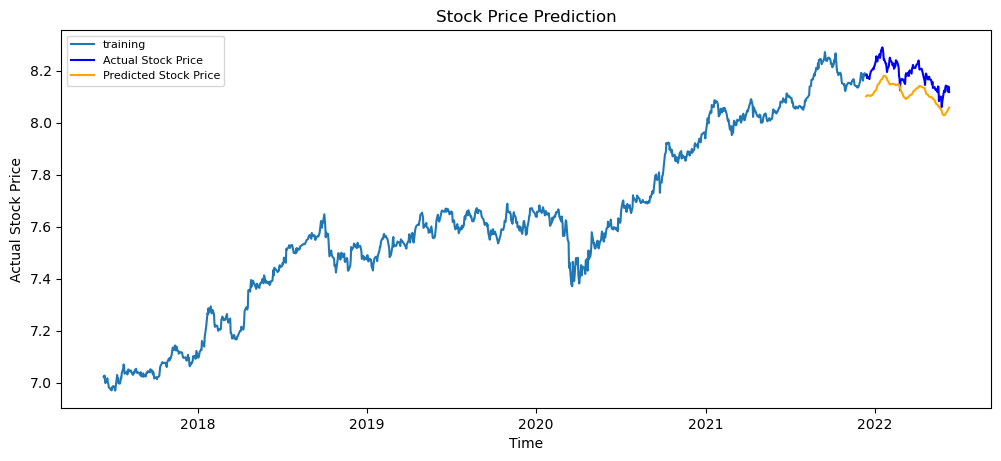

In [ ]:
#for plotting
def create_lstm_forecasting(split_data):
    plt.figure(figsize=(12,5), dpi=100)
    #for plotting
    train = close_stocks_data[:len(lstm_train)]
    test = close_stocks_data[len(lstm_train):]
    lstm_Predictions = lstm_close_stocks_predictions
    plt.plot(train,label='training')
    plt.plot(test, color = 'blue', label='Actual Stock Price')
    plt.plot(lstm_Predictions, color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
create_lstm_forecasting(split_data)

In [ ]:
lstm_rmse = math.sqrt(mean_squared_error(lstm_test, LSTM_forcast))
print('RMSE: '+str(lstm_rmse))
lstm_mape = np.mean(np.abs(LSTM_forcast - lstm_test)/np.abs(lstm_test))
print('MAPE: '+str(lstm_mape))

RMSE: 0.07855217479739551
MAPE: 0.009915997116147525


# Holts winter exponential smoothing with additive seasonality and additive trend

In [ ]:
x = 12
alpha = 1/(2*x)

### Single exponential smoothing

<AxesSubplot:title={'center':'Holt Winters Single Exponential Smoothing grpah'}, xlabel='Date'>

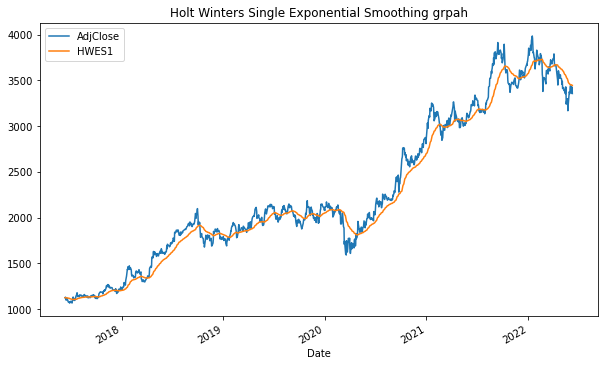

In [ ]:
# Single exponential smoothing 
stocks_data['HWES1'] = SimpleExpSmoothing(stocks_data['AdjClose']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues      
stocks_data[['AdjClose','HWES1']].plot(title='Holt Winters Single Exponential Smoothing grpah')

In [ ]:
stocks_data

,Open,High,Low,Close,AdjClose,Volume,HWES1
Date,,,,,,,
2017-06-12,1248.500000,1256.449951,1235.199951,1243.599976,1122.983276,1626506,1122.983276
2017-06-13,1232.500000,1240.550049,1223.500000,1225.775024,1119.262207,1175414,1122.983276
2017-06-14,1227.500000,1238.000000,1227.500000,1235.099976,1127.776855,1489142,1122.828232
2017-06-15,1234.500000,1234.849976,1202.500000,1205.599976,1100.840210,2997198,1123.034424
2017-06-16,1207.474976,1217.500000,1193.250000,1199.849976,1095.589966,2450426,1122.109666
...,...,...,...,...,...,...,...
2022-06-06,3418.000000,3453.000000,3377.149902,3430.949951,3430.949951,1084210,3451.596539
2022-06-07,3401.050049,3418.850098,3356.000000,3362.699951,3362.699951,2308256,3450.736265
2022-06-08,3380.149902,3413.949951,3346.500000,3404.149902,3404.149902,2185707,3447.068085


### Double exponential smoothing

<AxesSubplot:title={'center':'Holt Winters grapg: Additive Trend and Multiplicative Trend'}, xlabel='Date'>

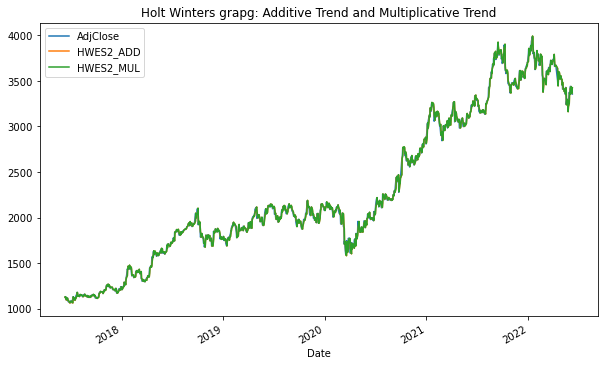

In [ ]:
stocks_data['HWES2_ADD'] = ExponentialSmoothing(stocks_data['AdjClose'],trend='add').fit().fittedvalues
stocks_data['HWES2_MUL'] = ExponentialSmoothing(stocks_data['AdjClose'],trend='mul').fit().fittedvalues
stocks_data[['AdjClose','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters grapg: Additive Trend and Multiplicative Trend')

In [ ]:
stocks_data

,Open,High,Low,Close,AdjClose,Volume,HWES1,HWES2_ADD,HWES2_MUL
Date,,,,,,,,,
2017-06-12,1248.500000,1256.449951,1235.199951,1243.599976,1122.983276,1626506,1122.983276,1124.555791,1128.527885
2017-06-13,1232.500000,1240.550049,1223.500000,1225.775024,1119.262207,1175414,1122.983276,1118.939224,1122.936559
2017-06-14,1227.500000,1238.000000,1227.500000,1235.099976,1127.776855,1489142,1122.828232,1115.171254,1119.080463
2017-06-15,1234.500000,1234.849976,1202.500000,1205.599976,1100.840210,2997198,1123.034424,1123.618199,1127.436390
2017-06-16,1207.474976,1217.500000,1193.250000,1199.849976,1095.589966,2450426,1122.109666,1097.180728,1100.926387
...,...,...,...,...,...,...,...,...,...
2022-06-06,3418.000000,3453.000000,3377.149902,3430.949951,3430.949951,1084210,3451.596539,3437.779104,3438.346182
2022-06-07,3401.050049,3418.850098,3356.000000,3362.699951,3362.699951,2308256,3450.736265,3429.233186,3429.790275
2022-06-08,3380.149902,3413.949951,3346.500000,3404.149902,3404.149902,2185707,3447.068085,3361.194120,3361.794233


In [ ]:
# Split into train and test set
train_stocks = split_data["train_data"]
test_stocks = split_data["test_data"]

### Fit Model

In [ ]:
ExponentialSmoothing_fitted_model = ExponentialSmoothing(train_stocks,trend='mul',seasonal='mul',seasonal_periods=2).fit()
Holt_forecast = ExponentialSmoothing_fitted_model.forecast(lenTestData)  # 95% conf

In [ ]:
tmp_holt_dataset = np.array(Holt_forecast.values.tolist())
tmp_test_data = test_stocks.reset_index()
holt_close_stocks_predictions = pd.DataFrame(index=range(0,len(tmp_holt_dataset)),columns=['Date', 'Prediction'])
for i in range(0,len(tmp_holt_dataset)):
    holt_close_stocks_predictions['Date'][i] = tmp_test_data['Date'][i].date()
    holt_close_stocks_predictions['Prediction'][i] = tmp_holt_dataset[i]
      
    
holt_close_stocks_predictions.set_index('Date',inplace=True)    
holt_close_stocks_predictions


,Prediction
Date,
2021-12-13,8.19236
2021-12-14,8.19261
2021-12-15,8.19457
2021-12-16,8.19482
2021-12-17,8.19679
...,...
2022-06-06,8.32434
2022-06-07,8.32634
2022-06-08,8.32659


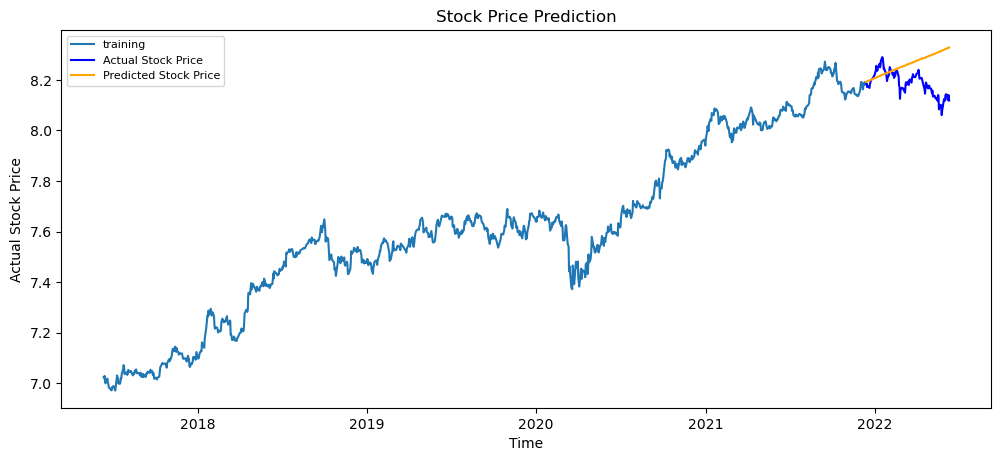

In [ ]:

def create_holts_forecasting():
    plt.figure(figsize=(12,5), dpi=100)
    #for plotting
    train = close_stocks_data[:len(train_stocks)]
    test = close_stocks_data[len(train_stocks):]
    plt.plot(train_stocks,label='training')
    plt.plot(test_stocks, color = 'blue', label='Actual Stock Price')
    plt.plot(holt_close_stocks_predictions, color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
create_holts_forecasting()

In [ ]:
holt_tst_data = np.array(test_stocks.values.tolist()) 
Holt_forecast = np.array(Holt_forecast.values.tolist())

holts_rmse = math.sqrt(mean_squared_error(holt_tst_data, Holt_forecast))
print('RMSE: '+str(holts_rmse))
holts_mape = np.mean(np.abs(Holt_forecast - holt_tst_data)/np.abs(holt_tst_data))
print('MAPE: '+str(holts_mape))

RMSE: 0.10836047344989616
MAPE: 0.01020337796432767


In [ ]:
data = [[arima_rmse,arima_mape.Prediction], [lstm_rmse,lstm_mape], [holts_rmse,holts_mape]]
df = pd.DataFrame(data, columns=['RMSE','MAPE'],index=['Arima',
                               'LSTM',
                               'HOLTS'])
df

,RMSE,MAPE
Arima,0.103100,0.009691
LSTM,0.078552,0.009916
HOLTS,0.108360,0.010203


# We choose LSTM as best model for forecasting the stock time series data

#### Store model in file

In [ ]:
from keras.models import load_model
fileName = 'model/model_lstm_'+companyCode+'.h5'
LSTM_model.save(fileName)  # pickle won't work for LSTM, so use this way

### Next 30 days Stocks Prediction Using LSTM

In [ ]:
past_reference_data = 60 
next_future_days = 30

In [ ]:
LSTM_test_data = split_data["test_data"]
len(LSTM_test_data)

124

In [ ]:
x_input=LSTM_test_data[len(LSTM_test_data)-past_reference_data:].values.reshape(-1,1)
x_input = scaler.transform(x_input)
x_input = x_input.reshape(1,-1)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=past_reference_data
i=0
while(i<next_future_days):
    
    if(len(temp_input)>past_reference_data):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = LSTM_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = LSTM_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8248906]
61
1 day input [0.92956347 0.93304731 0.92348816 0.9388421  0.94118234 0.9487867
 0.94017153 0.94022261 0.93974228 0.94508035 0.94678385 0.95058267
 0.95291716 0.96179661 0.94989707 0.93539518 0.93570358 0.93791012
 0.93682309 0.93081622 0.90259501 0.89044047 0.9087437  0.92389536
 0.92052652 0.90690966 0.90650388 0.90968034 0.91457877 0.90658931
 0.90567023 0.89215152 0.89944254 0.88181592 0.8845698  0.88317207
 0.87725562 0.8765114  0.87789921 0.86939918 0.88599787 0.88538298
 0.84318342 0.85036086 0.85694654 0.84920966 0.82604507 0.84009672
 0.84811864 0.87413748 0.87168693 0.86962364 0.8847803  0.88856658
 0.88653781 0.87131525 0.88059671 0.88568722 0.86979297 0.82489061]
1 day output [[0.82090354]]
2 day input [0.93304731 0.92348816 0.9388421  0.94118234 0.9487867  0.94017153
 0.94022261 0.93974228 0.94508035 0.94678385 0.95058267 0.95291716
 0.96179661 0.94989707 0.93539518 0.93570358 0.93791012 0.93682309
 0.93081622 0.90259501 0.89044047 0.9087437  0.92389536 0.9205

15 day output [[0.71051013]]
16 day input [0.93539518 0.93570358 0.93791012 0.93682309 0.93081622 0.90259501
 0.89044047 0.9087437  0.92389536 0.92052652 0.90690966 0.90650388
 0.90968034 0.91457877 0.90658931 0.90567023 0.89215152 0.89944254
 0.88181592 0.8845698  0.88317207 0.87725562 0.8765114  0.87789921
 0.86939918 0.88599787 0.88538298 0.84318342 0.85036086 0.85694654
 0.84920966 0.82604507 0.84009672 0.84811864 0.87413748 0.87168693
 0.86962364 0.8847803  0.88856658 0.88653781 0.87131525 0.88059671
 0.88568722 0.86979297 0.82489061 0.82090354 0.81483442 0.80752498
 0.79951429 0.79114532 0.78263086 0.77410412 0.76564521 0.75730157
 0.74910057 0.74105626 0.73317468 0.72545797 0.71790397 0.71051013]
16 day output [[0.70327234]]
17 day input [0.93570358 0.93791012 0.93682309 0.93081622 0.90259501 0.89044047
 0.9087437  0.92389536 0.92052652 0.90690966 0.90650388 0.90968034
 0.91457877 0.90658931 0.90567023 0.89215152 0.89944254 0.88181592
 0.8845698  0.88317207 0.87725562 0.8765114 

In [ ]:
day_new=np.arange(1,past_reference_data+1)
day_pred=np.arange(past_reference_data+1,past_reference_data+1+next_future_days)

In [ ]:
lst_output

[[0.8248906135559082],
 [0.8209035396575928],
 [0.8148344159126282],
 [0.8075249791145325],
 [0.7995142936706543],
 [0.7911453247070312],
 [0.7826308608055115],
 [0.774104118347168],
 [0.7656452059745789],
 [0.7573015689849854],
 [0.7491005659103394],
 [0.7410562634468079],
 [0.7331746816635132],
 [0.7254579663276672],
 [0.7179039716720581],
 [0.7105101346969604],
 [0.7032723426818848],
 [0.6961858868598938],
 [0.6892462968826294],
 [0.6824485659599304],
 [0.6757882237434387],
 [0.6692608594894409],
 [0.6628621816635132],
 [0.6565879583358765],
 [0.6504343152046204],
 [0.6443977952003479],
 [0.6384745836257935],
 [0.6326618194580078],
 [0.6269561052322388],
 [0.6213544011116028]]

In [ ]:
from datetime import timedelta
from datetime import date
lstm_nxt30_stocks = np.exp(scaler.inverse_transform(lst_output))
future_30days_stock_predictions = pd.DataFrame(index=range(0,next_future_days),columns=['Date', 'Prediction'])
Begindate = date.today()
for i in range(0,next_future_days):
    future_30days_stock_predictions['Date'][i] = Begindate + timedelta(days=i+1)
    future_30days_stock_predictions['Prediction'][i] = lstm_nxt30_stocks[i][0]
      
    
future_30days_stock_predictions.set_index('Date',inplace=True)    
future_30days_stock_predictions

,Prediction
Date,
2022-06-11,3162.83
2022-06-12,3146.23
2022-06-13,3121.12
2022-06-14,3091.15
2022-06-15,3058.64
2022-06-16,3025.04
2022-06-17,2991.23
2022-06-18,2957.76
2022-06-19,2924.91


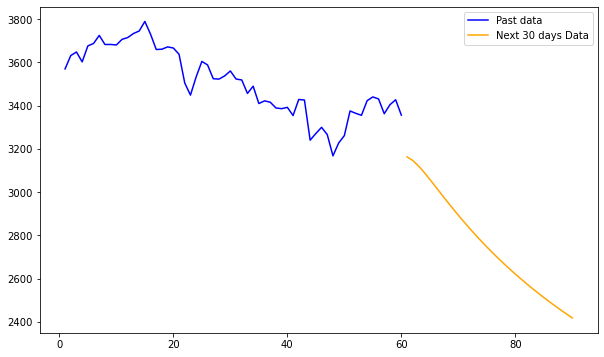

In [ ]:
plt.plot(day_new,np.exp(scaler.inverse_transform(scaled_data[len(scaled_data)-past_reference_data:])),color = 'blue',label='Past data')
plt.plot(day_pred,lstm_nxt30_stocks,color = 'orange',label='Next 30 days Data')
plt.legend()
plt.show()